In [41]:
import numpy as np
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

In [67]:
start_year = 2022
end_year = 2023

# load and concat WRDS data for all years
wrds_data = []
for year in range(start_year, end_year + 1):
    df_year = pd.read_csv(f'Data/sp500_cleaned_{year}.csv')
    wrds_data.append(df_year)

wrds_file = pd.concat(wrds_data, ignore_index=True)

In [68]:
print(wrds_file.isna().sum().sum()) # should be 0; else something's wrong
print(wrds_file.shape)
print("Unique tickers:", wrds_file['ticker'].nunique())

0
(10304, 68)
Unique tickers: 444


In [69]:
# set index
# wrds_file.set_index(['ticker', 'date'], inplace=True)
wrds_file.columns

Index(['date', 'ticker', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi',
       'ps', 'pcf', 'dpr', 'npm', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe',
       'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 'aftret_equity',
       'GProf', 'equity_invcap', 'debt_invcap', 'totdebt_invcap',
       'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'debt_at',
       'debt_ebitda', 'short_debt', 'lt_debt', 'cash_debt', 'fcf_ocf',
       'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio',
       'at_turn', 'rect_turn', 'pay_turn', 'sale_equity', 'rd_sale',
       'adv_sale', 'staff_sale', 'accrual', 'ptb', 'divyield', 'volume',
       'price', 'SMA_3', 'SMA_6', 'ret_1m', 'ret_3m', 'ret_6m', 'vol_3m',
       'vol_6m', 'EMA_6', 'EMA_12', 'RSI', 'MACD_ratio', 'vol_SMA_3',
       'vol_SMA_6', 'vol_ROC', 'OBV'],
      dtype='object')

Standardizing

In [70]:
wrds_file.describe()

,bm,evm,pe_op_basic,pe_op_dil,pe_exi,ps,pcf,dpr,npm,opmad,...,vol_3m,vol_6m,EMA_6,EMA_12,RSI,MACD_ratio,vol_SMA_3,vol_SMA_6,vol_ROC,OBV
count,10304.000000,10304.000000,10304.000000,10304.000000,10304.000000,10304.000000,10304.000000,10304.000000,10304.000000,10304.000000,...,10304.000000,10304.000000,10304.000000,10304.000000,10304.000000,10304.000000,1.030400e+04,1.030400e+04,10304.000000,1.030400e+04
mean,0.393680,17.328654,21.268700,22.586269,22.971189,3.627251,19.205158,0.654367,0.135415,0.206995,...,0.088102,0.091741,185.449180,186.515434,48.807990,-0.011314,1.060087e+08,1.053382e+08,0.049756,1.358828e+09
std,0.335487,131.375221,53.873388,37.631189,68.570409,3.565259,28.996178,4.297406,0.133906,0.137719,...,0.054271,0.050633,338.871471,333.006563,21.676262,0.323233,2.152944e+08,2.115751e+08,0.424226,3.607436e+09
min,0.000000,-3723.700000,-1963.400000,-547.730000,-2621.200000,0.081000,-375.180000,-5.885000,-2.150000,-0.331000,...,0.000363,0.009313,7.262706,8.766933,0.000000,-8.778280,3.698843e+05,3.805802e+05,-0.864249,-1.421250e+10
25%,0.150750,10.259000,11.476000,11.621500,11.884500,1.337750,8.114750,0.084750,0.071000,0.114000,...,0.050013,0.063214,62.060731,62.673553,33.048959,-0.018551,2.329683e+07,2.321105e+07,-0.166490,2.660140e+08
50%,0.299000,14.378000,18.957500,19.162500,20.406500,2.509000,14.706500,0.304000,0.121000,0.183000,...,0.078785,0.083675,108.931865,109.957975,48.537641,0.028046,4.534311e+07,4.466247e+07,-0.007493,6.443105e+08
75%,0.564000,20.275000,29.057000,29.358750,31.810250,4.537250,24.099750,0.544000,0.196000,0.275000,...,0.115698,0.110347,210.924187,212.290882,64.121431,0.065231,9.908987e+07,9.876728e+07,0.189700,1.362370e+09
max,3.067000,5622.390000,484.116000,496.424000,410.909000,47.108000,388.592000,188.000000,2.284000,0.722000,...,0.638771,2.923573,6223.782329,5887.310887,100.000000,0.527043,3.589500e+09,3.224458e+09,19.428166,5.619734e+10


In [71]:
# log for all volume related columns
volume_cols = ['volume', 'vol_SMA_3', 'vol_SMA_6']
wrds_file[volume_cols] = wrds_file[volume_cols].applymap(lambda x: np.log1p(x))

In [72]:
columns_to_standardize = wrds_file.columns.difference(['ticker', 'date']+volume_cols)
columns_to_standardize

Index(['EMA_12', 'EMA_6', 'GProf', 'MACD_ratio', 'OBV', 'RSI', 'SMA_3',
       'SMA_6', 'accrual', 'adv_sale', 'aftret_eq', 'aftret_equity',
       'aftret_invcapx', 'at_turn', 'bm', 'capital_ratio', 'cash_debt',
       'cash_lt', 'cfm', 'de_ratio', 'debt_assets', 'debt_at', 'debt_capital',
       'debt_ebitda', 'debt_invcap', 'divyield', 'dltt_be', 'dpr', 'efftax',
       'equity_invcap', 'evm', 'fcf_ocf', 'gpm', 'int_debt', 'int_totdebt',
       'lt_debt', 'lt_ppent', 'npm', 'opmad', 'pay_turn', 'pcf', 'pe_exi',
       'pe_op_basic', 'pe_op_dil', 'price', 'ps', 'ptb', 'ptpm', 'rd_sale',
       'rect_turn', 'ret_1m', 'ret_3m', 'ret_6m', 'roa', 'roce', 'roe',
       'sale_equity', 'short_debt', 'staff_sale', 'totdebt_invcap', 'vol_3m',
       'vol_6m', 'vol_ROC'],
      dtype='object')

In [34]:
# wrds_file[volume_cols]

In [73]:
wrds_file[columns_to_standardize] = wrds_file.groupby('date')[columns_to_standardize].transform(lambda x: (x - x.mean()) / x.std())

In [48]:
# wrds_file.describe()

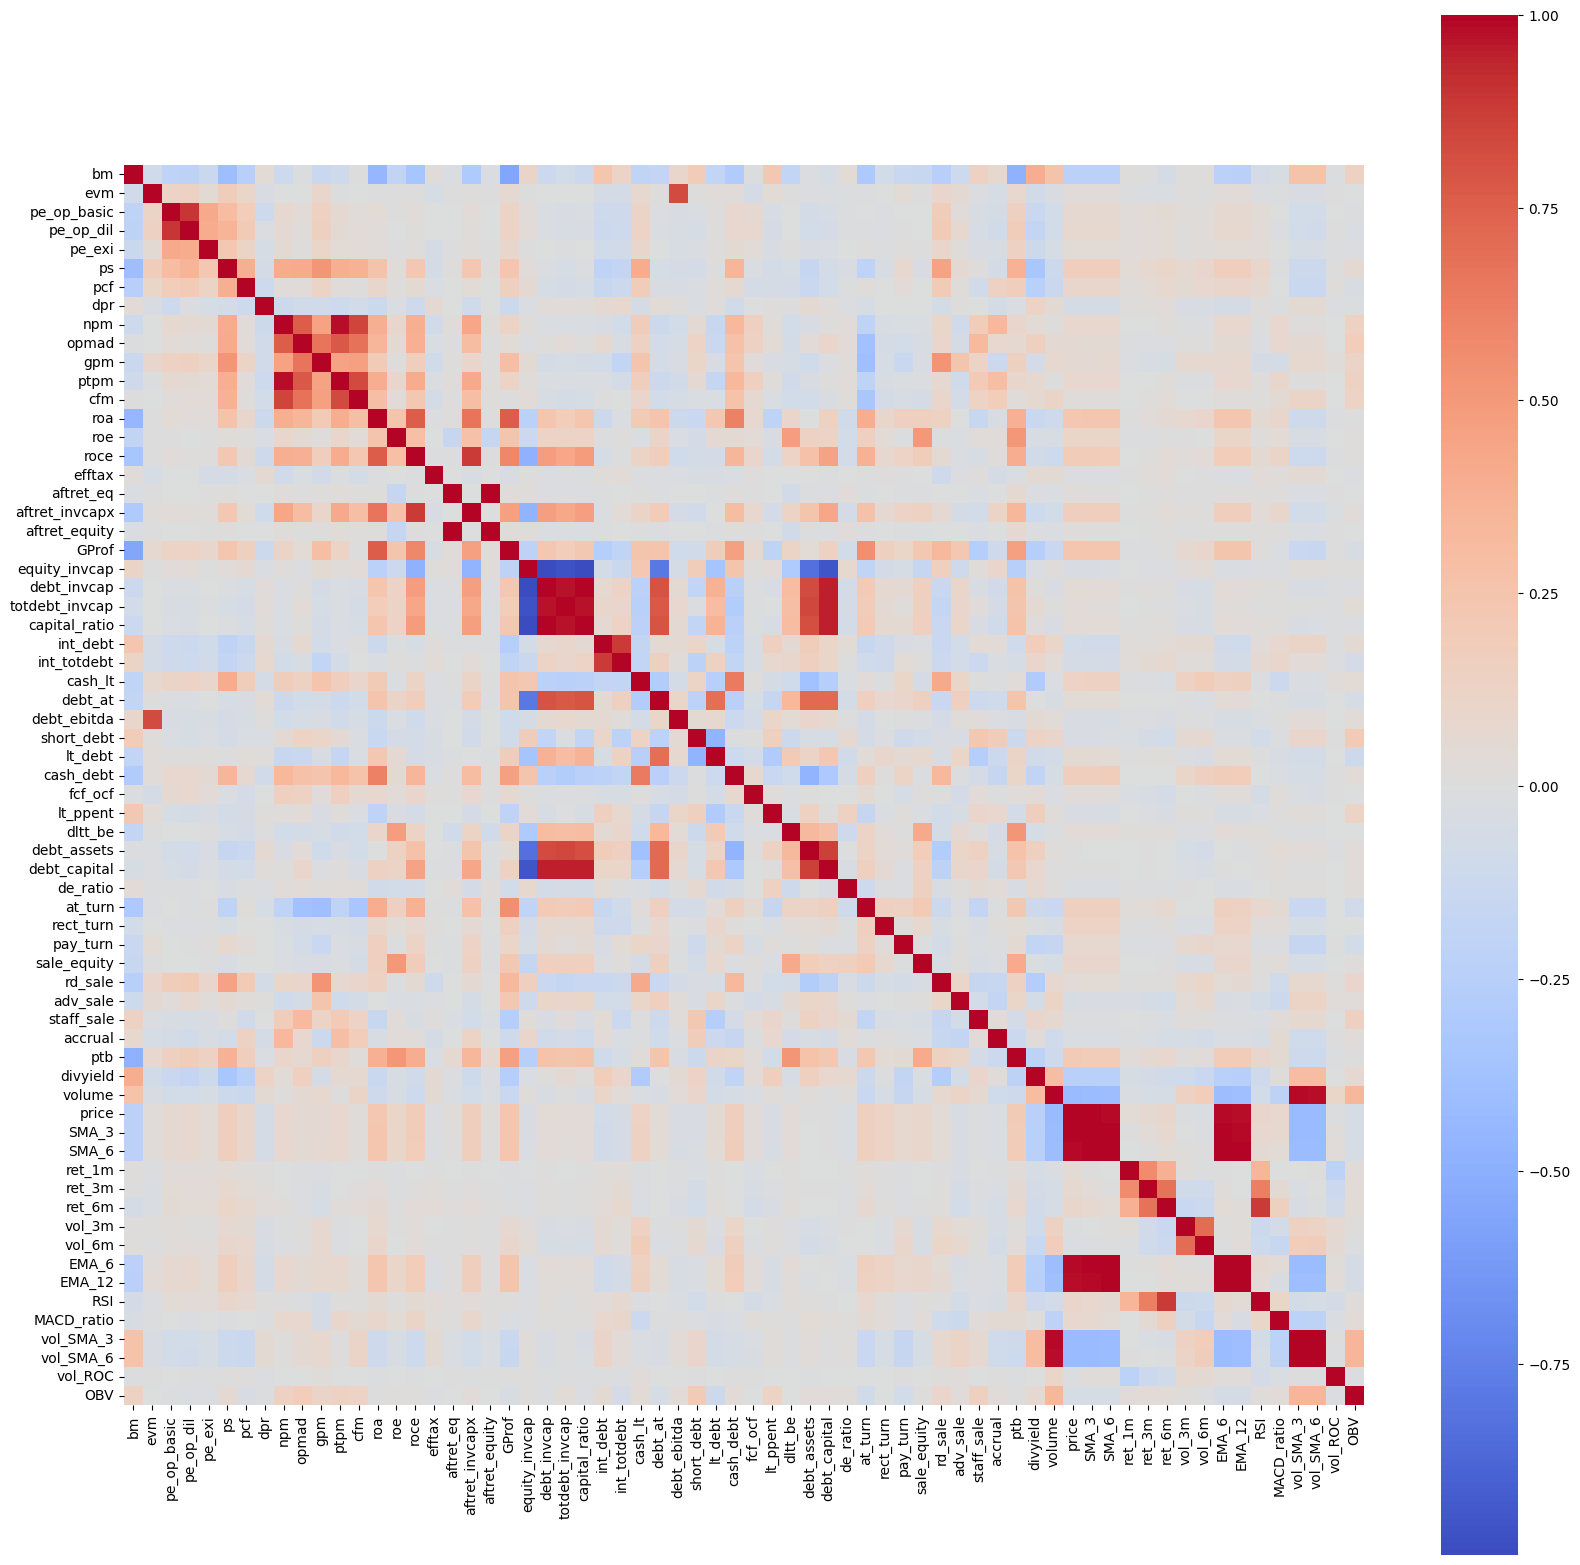

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 20))   
cols = wrds_file.select_dtypes(include='number').columns     # increase size
sns.heatmap(wrds_file[cols].corr(), 
            cmap='coolwarm', 
            square=True)
plt.show()


In [75]:
# find highly correlated features greater than 0.9
corr_matrix = wrds_file[cols].corr().abs()
threshold = 0.8
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_pairs = [(col1, col2, upper.loc[col1, col2]) for col1 in upper.columns for col2 in upper.columns
    if (col1 != col2) and pd.notna(upper.loc[col1, col2]) and (upper.loc[col1, col2] > threshold)]

# high_corr_pairs

In [76]:
len(high_corr_pairs)

38

# Regression

In [77]:
spy = pd.read_csv('Data/SPY.csv') # Date, SPY
spy["ret"] = spy["SPY"].pct_change()
spy.rename(columns={"Date": "date"}, inplace=True) # rename Date to date for merging
spy = spy[['date', 'ret']].dropna()
spy.head()

,date,ret
1,2019-02-28,0.032415
2,2019-03-31,0.018101
3,2019-04-30,0.040853
4,2019-05-31,-0.063771
5,2019-06-30,0.069587


In [78]:
# join wrds_file with spy returns on date
wrds_file = wrds_file.merge(spy, on='date', how='left')
wrds_file.head()

,date,ticker,bm,evm,pe_op_basic,pe_op_dil,pe_exi,ps,pcf,dpr,...,vol_6m,EMA_6,EMA_12,RSI,MACD_ratio,vol_SMA_3,vol_SMA_6,vol_ROC,OBV,ret
0,2022-01-31,A,-0.787831,0.241705,0.216967,0.212138,0.127428,0.535052,0.294298,-0.080634,...,0.073292,-0.155788,-0.159910,-0.566812,0.921173,17.396374,17.338859,0.071543,-0.207096,-0.052741
1,2022-02-28,A,-0.764504,-0.026674,0.202833,0.192829,0.122429,0.501740,0.063515,-0.103167,...,-0.496260,-0.164332,-0.163622,-1.614895,0.849921,17.469403,17.364766,0.203372,-0.213705,-0.029517
2,2022-03-31,A,-0.740715,-0.036771,0.191974,0.182694,0.098190,0.455208,0.050568,-0.101952,...,-0.558672,-0.173614,-0.168890,-1.455062,0.725420,17.572828,17.440082,-0.450693,-0.208228,0.037590
3,2022-04-30,A,-0.743225,-0.037103,0.175962,0.169278,0.095997,0.478729,0.064978,-0.101580,...,-0.484361,-0.182327,-0.174325,-1.078297,0.558993,17.603227,17.505139,0.410328,-0.206633,-0.087769
4,2022-05-31,A,-0.783077,0.088033,0.235566,0.224782,0.148613,0.650597,0.209871,-0.211126,...,-0.053721,-0.182158,-0.175467,-0.666746,0.421304,17.627171,17.551395,-0.621414,-0.198161,0.002257


In [79]:
wrds_file.columns

Index(['date', 'ticker', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi',
       'ps', 'pcf', 'dpr', 'npm', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe',
       'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 'aftret_equity',
       'GProf', 'equity_invcap', 'debt_invcap', 'totdebt_invcap',
       'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'debt_at',
       'debt_ebitda', 'short_debt', 'lt_debt', 'cash_debt', 'fcf_ocf',
       'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio',
       'at_turn', 'rect_turn', 'pay_turn', 'sale_equity', 'rd_sale',
       'adv_sale', 'staff_sale', 'accrual', 'ptb', 'divyield', 'volume',
       'price', 'SMA_3', 'SMA_6', 'ret_1m', 'ret_3m', 'ret_6m', 'vol_3m',
       'vol_6m', 'EMA_6', 'EMA_12', 'RSI', 'MACD_ratio', 'vol_SMA_3',
       'vol_SMA_6', 'vol_ROC', 'OBV', 'ret'],
      dtype='object')

In [84]:
# regression target: SPY returns 'ret' on each ticker
import pandas as pd
import statsmodels.api as sm

df = wrds_file.copy()
df = df.sort_values(["ticker", "date"])

# returns
df["stock_ret"] = df["ret_1m"]
df["mkt_ret"] = df["ret"]

# store residuals
residuals_list = []
for ticker, g in df.groupby("ticker"):
    if g["stock_ret"].notna().sum() < 12:  # require some history
        continue
        
    X = sm.add_constant(g["mkt_ret"])
    y = g["stock_ret"]
    model = sm.OLS(y, X, missing="drop").fit()
    g = g.assign(residual = model.resid)
    residuals_list.append(g)

df_resid = pd.concat(residuals_list).sort_values(["ticker", "date"])


In [98]:
factors = df.columns.difference(['ticker', 'date', 'ret_1m', 'stock_ret', 'mkt_ret', 'residual'])
factors

Index(['EMA_12', 'EMA_6', 'GProf', 'MACD_ratio', 'OBV', 'RSI', 'SMA_3',
       'SMA_6', 'accrual', 'adv_sale', 'aftret_eq', 'aftret_equity',
       'aftret_invcapx', 'at_turn', 'bm', 'capital_ratio', 'cash_debt',
       'cash_lt', 'cfm', 'de_ratio', 'debt_assets', 'debt_at', 'debt_capital',
       'debt_ebitda', 'debt_invcap', 'divyield', 'dltt_be', 'dpr', 'efftax',
       'equity_invcap', 'evm', 'fcf_ocf', 'gpm', 'int_debt', 'int_totdebt',
       'lt_debt', 'lt_ppent', 'npm', 'opmad', 'pay_turn', 'pcf', 'pe_exi',
       'pe_op_basic', 'pe_op_dil', 'price', 'ps', 'ptb', 'ptpm', 'rd_sale',
       'rect_turn', 'ret', 'ret_3m', 'ret_6m', 'roa', 'roce', 'roe',
       'sale_equity', 'short_debt', 'staff_sale', 'totdebt_invcap', 'vol_3m',
       'vol_6m', 'vol_ROC', 'vol_SMA_3', 'vol_SMA_6', 'volume'],
      dtype='object')

In [99]:
len(factors)

66

In [100]:
factor_loadings = []

for date, g in df_resid.groupby("date"):
    if g["residual"].notna().sum() < 20:
        continue
    
    X = sm.add_constant(g[factors])
    y = g["residual"]
    
    model = sm.OLS(y, X, missing="drop").fit()
    
    out = model.params
    out["date"] = date
    factor_loadings.append(out)

df_factor_loadings = pd.DataFrame(factor_loadings).set_index("date").sort_index()


In [101]:
df_factor_loadings.head()

,EMA_12,EMA_6,GProf,MACD_ratio,OBV,RSI,SMA_3,SMA_6,accrual,adv_sale,...,sale_equity,short_debt,staff_sale,totdebt_invcap,vol_3m,vol_6m,vol_ROC,vol_SMA_3,vol_SMA_6,volume
date,,,,,,,,,,,,,,,,,,,,,
2022-01-31,-3.463601,14.518439,-0.103672,-0.030779,-0.037042,-0.095844,-9.488183,-2.548258,-0.030228,0.008470,...,-0.056389,-0.041457,-0.000500,0.378384,-0.017213,-0.420562,-0.007638,0.775145,-0.221359,-0.426491
2022-02-28,2.704956,-8.099442,0.017918,0.110647,-0.012257,-0.186052,-6.594325,3.264525,0.021361,0.096629,...,-0.046387,0.034871,0.054680,-0.272704,-0.031525,0.240398,-0.057255,1.276548,-1.073675,-0.284780
2022-03-31,1.487722,-12.378696,0.034545,-0.150038,-0.039225,0.196444,-4.920616,12.103820,-0.034499,-0.115191,...,-0.002056,-0.062910,-0.016602,0.465214,0.281335,-0.096771,-0.157527,-1.185090,0.505028,0.622008
2022-04-30,0.552700,3.198289,0.252903,-0.007724,-0.035086,0.011862,-8.259653,2.046956,0.105334,0.025638,...,0.005403,-0.005085,0.019248,0.191484,-0.179228,-0.056476,-0.290833,-0.121861,-0.548938,0.728929
2022-05-31,-2.702252,20.670863,-0.106929,0.059587,0.021444,-0.298523,-11.391281,-9.458039,0.056685,0.078067,...,0.007707,-0.047172,-0.032754,-0.168787,0.211086,0.141704,-0.220719,-0.570402,0.072051,0.528002


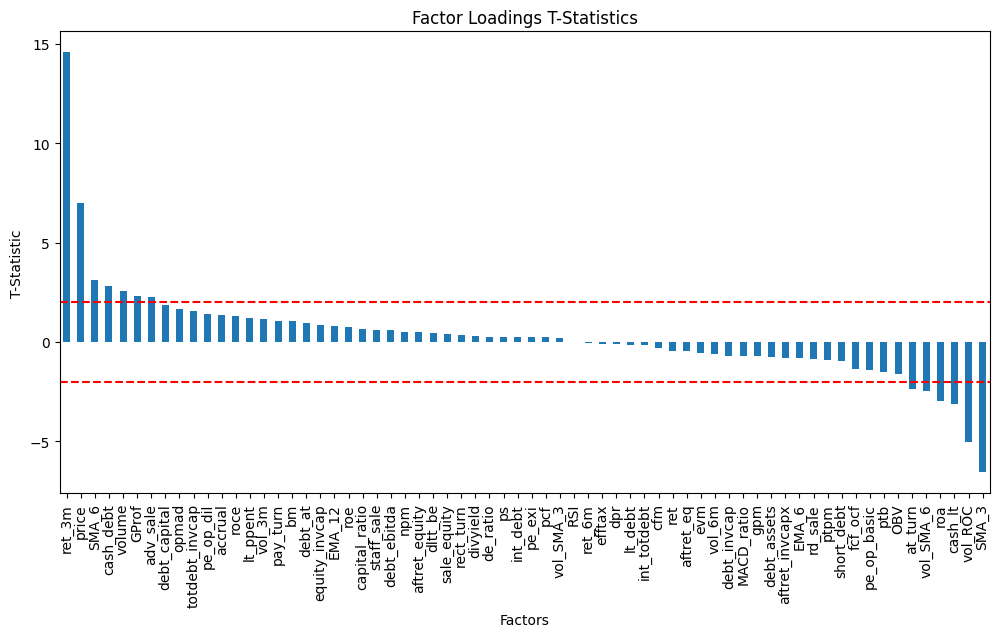

In [102]:
tstats = df_factor_loadings.mean() / (df_factor_loadings.std() / (len(df_factor_loadings) ** 0.5))
# sort t-statistics
tstats = tstats.sort_values(ascending=False)
# tstats.sort_values(ascending=False)
# plot t-statistics
plt.figure(figsize=(12, 6))
tstats.plot(kind='bar')
plt.title('Factor Loadings T-Statistics')
plt.xlabel('Factors')
plt.ylabel('T-Statistic')
plt.axhline(y=2, color='r', linestyle='--', label='Significance Threshold (2)')
plt.axhline(y=-2, color='r', linestyle='--')
plt.show()

